# 2021-11-18 • Constant input spikes

But vary tradeoff between number of inputs and each input's spike rate.

## Prelude

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Preloading: numpy, numba, matplotlib.pyplot, seaborn.
Importing from submodules … ✔
Imported `np`, `mpl`, `plt`, `sns`, `pd`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `lpxtf3` on `DUIP74576` on **Thu 18 Nov** 2021, at 18:48 (UTC+0000).<br>
[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/6034551337c7993a872386a1e0f0278f87fa57e9
) (Thu 18 Nov 2021, 17:05).
Uncommited changes to 3 files.

## Calculate

In [3]:
from voltage_to_wiring_sim.experiments.N_to_1_IE import Params, simulate_and_test_connections, eval_performance

In [4]:
base_params = Params()
v.pprint(base_params)

Params
------
     sim_duration = 600
         timestep = 0.0001
            τ_syn = 0.007
    neuron_params = {'C': 1e-10, 'a': 30.0, 'b': -2e-09, 'c': -0.05, ...}
imaging_spike_SNR = 20
  window_duration = 0.1
 num_spike_trains = 30
     p_inhibitory = 0.2
      p_connected = 0.7
       spike_rate = 20
       Δg_syn_exc = 4E-10
       Δg_syn_inh = 1.6E-09
        v_syn_exc = 0
        v_syn_inh = -0.065
         rng_seed = 0


In [5]:
@v.cache_to_disk(directory="2021-11-18__constant_input_spikes")
def sim_test_eval(params: Params):
    
    sim_data, _, test_summaries = simulate_and_test_connections(params)
    evalu_p_0_05, _, AUC, AUC_exc, AUC_inh = eval_performance(sim_data, test_summaries)
    
    output_spike_rate = sim_data.izh_output.spike_times.size / params.sim_duration
    
    return (output_spike_rate,
            evalu_p_0_05.TPR_exc, evalu_p_0_05.TPR_inh, evalu_p_0_05.FPR,
            AUC, AUC_exc, AUC_inh)

In [6]:
from dataclasses import replace
from itertools import product

In [7]:
spike_rates = np.array([0.1, 1, 10, 20]);  # of one input spike train, in Hz

In [13]:
def get_N(spike_rate):
    return round(30 * 20 / spike_rate)

In [16]:
Ns = np.vectorize(get_N)(spike_rates)

array([6000,  600,   60,   30])

In [18]:
seeds = [0];
# seeds = [0, 1, 2];
# seeds = [0, 1, 2, 3, 4, 5];
# seeds = np.arange(20);

In [19]:
f = sim_test_eval
args = [replace(base_params,
                spike_rate=rate,
                num_spike_trains=get_N(rate),
                rng_seed=seed,
        )
        for (rate, seed) in product(spike_rates, seeds)];

In [20]:
%%time
results = v.run_in_parallel(f, args);

MemoryError: Unable to allocate 45.8 MiB for an array with shape (6000000,) and data type float64

In [24]:
num_samples = 600 * 1000 * 10
num_arrays = 6000
byte_per_sample = 64 / 8
mem_needed_for_gsyns = num_samples * num_arrays * byte_per_sample / 1E9  # GB

288

In [21]:
M = np.reshape(results, (len(spike_rates), len(seeds), -1))

(output_spike_rate, 
 TPR_exc, TPR_inh, FPR,
 AUC, AUC_exc, AUC_inh) = (M[:,:,i] for i in range(M.shape[-1]))

NameError: name 'results' is not defined

## Plot

In [95]:
def plot_dots_and_mean(data, ax, x, c="0.2", label=None, ms=6, lw=5):
    ax.plot(x, data, "o", alpha=0.3, c=c, ms=ms)
    ax.plot(x, np.mean(data, axis=-1), "-", c=c, label=label, lw=lw)
    
smaller = dict(ms=4, lw=3);

In [96]:
def make_inv_ratio_ax():
    fig, ax = plt.subplots()

    ax.set_xscale('log')
    ax.set_xticks(spike_rates)
    ax.set_xticklabels(f"{r:g}" for r in spike_rates)

    ax.set_xlabel("Spike rate per input (Hz)$")

    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/secondary_axis.html
    def one_over(x):
        x = np.array(x).astype(float)
        near_zero = np.isclose(x, 0)
        x[near_zero] = np.inf
        x[~near_zero] = 1 / x[~near_zero]
        return x

    sax = ax.secondary_xaxis("top", functions=(one_over, one_over))

    sax.set_xticks(Ns)
    sax.set_xticks([], minor=True)
    sax.set_xticklabels(f"{r:.3g}" for r in Ns)
    sax.set_xlabel("Number of inputs$", labelpad=8)
    
    return fig, ax

plot = partial(plot_dots_and_mean, x=spike_rates);

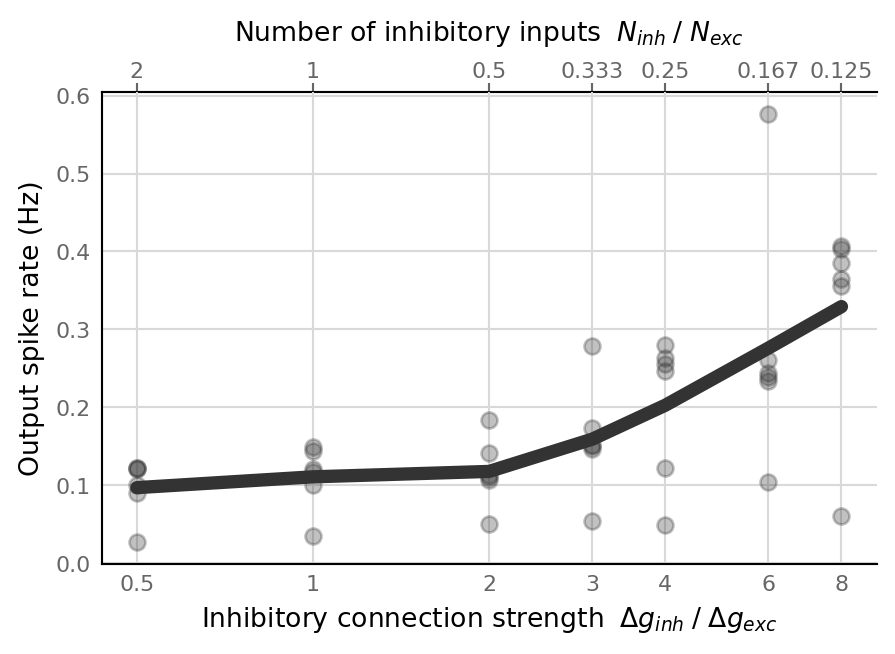

In [97]:
fig, ax = make_inv_ratio_ax()
plot(output_spike_rate, ax)
ax.set_ylabel("Output spike rate (Hz)");

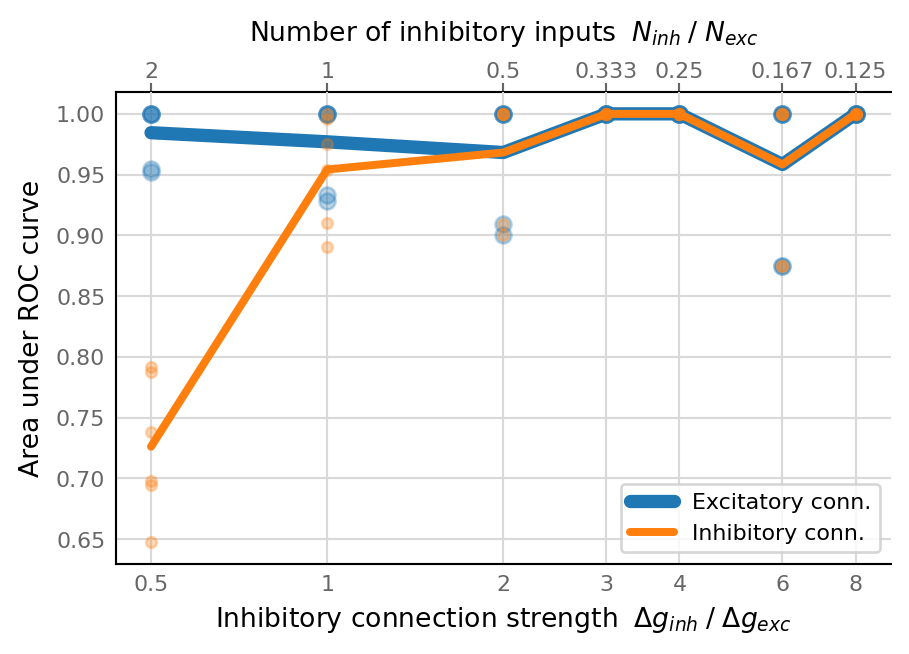

In [98]:
fig, ax = make_inv_ratio_ax()
plot(AUC_exc, ax, c=v.color_exc, label="Excitatory conn.")
plot(AUC_inh, ax, c=v.color_inh, label="Inhibitory conn.", **smaller)
ax.set_ylabel("Area under ROC curve")
ax.legend();

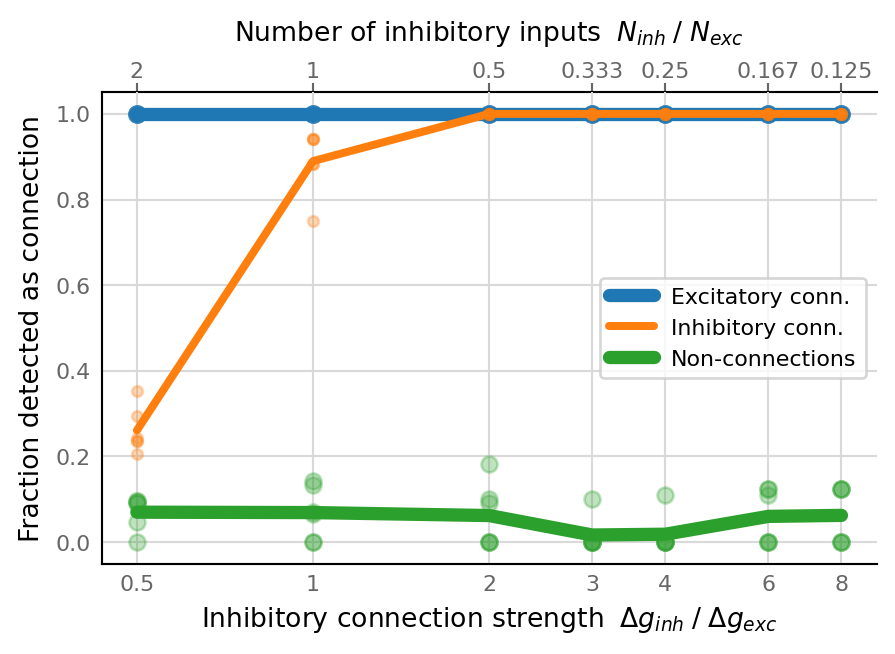

In [99]:
fig, ax = make_inv_ratio_ax()
plot(TPR_exc, ax, c=v.color_exc, label="Excitatory conn.")
plot(TPR_inh, ax, c=v.color_inh, label="Inhibitory conn.", **smaller)
plot(FPR, ax, c=v.color_unconn, label="Non-connections")
ax.set_ylabel("Fraction detected as connection")
ax.legend();

## Inspect signals

In [42]:
sim_and_test = v.cache_to_disk(simulate_and_test_connections);

## Reproducibility

In [158]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `lpxtf3` on `DUIP74576`<br>on **Thu 18 Nov** 2021, at 16:55 (UTC+0000).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/a715f3fe3292b887aa6be85fe2f9955d4c95d3c6
) (Fri 12 Nov 2021, 00:23).

Uncommited changes to:
```
 M ReadMe.md
 M codebase/voltage_to_wiring_sim/__init__.py
 M codebase/voltage_to_wiring_sim/experiments/N_to_1.py
 M codebase/voltage_to_wiring_sim/support/__init__.py
AM codebase/voltage_to_wiring_sim/support/high_performance.py
 M codebase/voltage_to_wiring_sim/support/misc.py
 M notebooks/2021-01-02__full_network_sim_tryout.ipynb
 M notebooks/2021-11-11__vary_both_inh_strength_and_proportion.ipynb
 M website/thesis/references.bib
```

Platform:

Windows-10
CPython 3.9.6 (C:\miniforge3\python.exe)
Intel(R) Xeon(R) W-2123 CPU @ 3.60GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.21.1
matplotlib           3.4.2
numba                0.53.1
joblib               1.0.1
seaborn              0.11.1
scipy                1.7.0
preload              2.2
nptyping             1.4.2


Full conda list:

```
# packages in environment at C:\miniforge3:
#
# Name                    Version                   Build  Channel
argon2-cffi               20.1.0           py39hb82d6ee_2    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
black                     21.9b0             pyhd8ed1ab_1    conda-forge
bleach                    3.3.1              pyhd8ed1ab_0    conda-forge
brotlipy                  0.7.0           py39hb82d6ee_1001    conda-forge
ca-certificates           2021.10.8            h5b45459_0    conda-forge
certifi                   2021.10.8        py39hcbf5309_1    conda-forge
cffi                      1.14.6           py39h0878f49_0    conda-forge
chardet                   4.0.0            py39hcbf5309_1    conda-forge
charset-normalizer        2.0.0              pyhd8ed1ab_0    conda-forge
click                     7.1.2                    pypi_0    pypi
colorama                  0.4.4              pyh9f0ad1d_0    conda-forge
colorful                  0.5.4                    pypi_0    pypi
conda                     4.10.3           py39hcbf5309_2    conda-forge
conda-package-handling    1.7.3            py39hb3671d1_0    conda-forge
cryptography              3.4.7            py39hd8d06c1_0    conda-forge
cycler                    0.10.0                   pypi_0    pypi
dataclasses               0.8                pyhc8e2a94_3    conda-forge
debugpy                   1.4.1            py39h415ef7b_0    conda-forge
decorator                 5.0.9              pyhd8ed1ab_0    conda-forge
defusedxml                0.7.1              pyhd8ed1ab_0    conda-forge
entrypoints               0.3             pyhd8ed1ab_1003    conda-forge
icu                       68.2                 h0e60522_0    conda-forge
idna                      3.1                pyhd3deb0d_0    conda-forge
importlib-metadata        4.6.1            py39hcbf5309_0    conda-forge
ipykernel                 6.0.3            py39h832f523_0    conda-forge
ipython                   7.25.0           py39h832f523_1    conda-forge
ipython_genutils          0.2.0                      py_1    conda-forge
jedi                      0.18.0           py39hcbf5309_2    conda-forge
jinja2                    3.0.1              pyhd8ed1ab_0    conda-forge
joblib                    1.0.1                    pypi_0    pypi
jpeg                      9d                   h8ffe710_0    conda-forge
jsonschema                3.2.0              pyhd8ed1ab_3    conda-forge
jupyter_client            6.1.12             pyhd8ed1ab_0    conda-forge
jupyter_contrib_core      0.3.3                      py_2    conda-forge
jupyter_contrib_nbextensions 0.5.1              pyhd8ed1ab_2    conda-forge
jupyter_core              4.7.1            py39hcbf5309_0    conda-forge
jupyter_highlight_selected_word 0.2.0           py39hcbf5309_1002    conda-forge
jupyter_latex_envs        1.4.6           pyhd8ed1ab_1002    conda-forge
jupyter_nbextensions_configurator 0.4.1            py39hcbf5309_2    conda-forge
jupyterlab_pygments       0.1.2              pyh9f0ad1d_0    conda-forge
kiwisolver                1.3.1                    pypi_0    pypi
libclang                  11.1.0          default_h5c34c98_1    conda-forge
libiconv                  1.16                 he774522_0    conda-forge
libpng                    1.6.37               h1d00b33_2    conda-forge
libsodium                 1.0.18               h8d14728_1    conda-forge
libxml2                   2.9.12               hf5bbc77_0    conda-forge
libxslt                   1.1.33               h65864e5_2    conda-forge
libzlib                   1.2.11            h8ffe710_1013    conda-forge
llvmlite                  0.36.0                   pypi_0    pypi
lxml                      4.6.3            py39h4fd7cdf_0    conda-forge
markupsafe                2.0.1            py39hb82d6ee_0    conda-forge
matplotlib                3.4.2                    pypi_0    pypi
matplotlib-inline         0.1.2              pyhd8ed1ab_2    conda-forge
menuinst                  1.4.17           py39hcbf5309_1    conda-forge
miniforge_console_shortcut 2.0                  h57928b3_0    conda-forge
mistune                   0.8.4           py39hb82d6ee_1004    conda-forge
mypy_extensions           0.4.3            py39hcbf5309_4    conda-forge
nbclient                  0.5.3              pyhd8ed1ab_0    conda-forge
nbconvert                 6.1.0            py39hcbf5309_0    conda-forge
nbformat                  5.1.3              pyhd8ed1ab_0    conda-forge
nest-asyncio              1.5.1              pyhd8ed1ab_0    conda-forge
notebook                  6.4.0              pyha770c72_0    conda-forge
nptyping                  1.4.2                    pypi_0    pypi
numba                     0.53.1                   pypi_0    pypi
numpy                     1.21.1                   pypi_0    pypi
openssl                   1.1.1l               h8ffe710_0    conda-forge
packaging                 21.0               pyhd8ed1ab_0    conda-forge
pandas                    1.3.1                    pypi_0    pypi
pandoc                    2.14.1               h8ffe710_0    conda-forge
pandocfilters             1.4.2                      py_1    conda-forge
parso                     0.8.2              pyhd8ed1ab_0    conda-forge
pathspec                  0.9.0              pyhd8ed1ab_0    conda-forge
pickleshare               0.7.5                   py_1003    conda-forge
pillow                    8.3.1                    pypi_0    pypi
pip                       21.2.1             pyhd8ed1ab_0    conda-forge
platformdirs              2.3.0              pyhd8ed1ab_0    conda-forge
preload                   2.2                      pypi_0    pypi
prettyprinter             0.18.0                   pypi_0    pypi
prometheus_client         0.11.0             pyhd8ed1ab_0    conda-forge
prompt-toolkit            3.0.19             pyha770c72_0    conda-forge
pycosat                   0.6.3           py39hb82d6ee_1006    conda-forge
pycparser                 2.20               pyh9f0ad1d_2    conda-forge
pygments                  2.9.0              pyhd8ed1ab_0    conda-forge
pympler                   0.9                      pypi_0    pypi
pyopenssl                 20.0.1             pyhd8ed1ab_0    conda-forge
pyparsing                 2.4.7              pyh9f0ad1d_0    conda-forge
pyqt                      5.12.3           py39hcbf5309_7    conda-forge
pyqt-impl                 5.12.3           py39h415ef7b_7    conda-forge
pyqt5-sip                 4.19.18          py39h415ef7b_7    conda-forge
pyqtchart                 5.12             py39h415ef7b_7    conda-forge
pyqtwebengine             5.12.1           py39h415ef7b_7    conda-forge
pyrsistent                0.17.3           py39hb82d6ee_2    conda-forge
pysocks                   1.7.1            py39hcbf5309_3    conda-forge
python                    3.9.6           h7840368_1_cpython    conda-forge
python-dateutil           2.8.2              pyhd8ed1ab_0    conda-forge
python_abi                3.9                      2_cp39    conda-forge
pytz                      2021.1                   pypi_0    pypi
pywin32                   300              py39hb82d6ee_0    conda-forge
pywinpty                  1.1.3            py39h99910a6_0    conda-forge
pyyaml                    6.0              py39hb82d6ee_0    conda-forge
pyzmq                     22.1.0           py39he46f08e_0    conda-forge
qt                        5.12.9               h5909a2a_4    conda-forge
regex                     2021.10.23       py39hb82d6ee_1    conda-forge
requests                  2.26.0             pyhd8ed1ab_0    conda-forge
ruamel_yaml               0.15.80         py39hb82d6ee_1004    conda-forge
scipy                     1.7.0                    pypi_0    pypi
seaborn                   0.11.1                   pypi_0    pypi
send2trash                1.7.1              pyhd8ed1ab_0    conda-forge
setuptools                49.6.0           py39hcbf5309_3    conda-forge
six                       1.16.0             pyh6c4a22f_0    conda-forge
sqlite                    3.36.0               h8ffe710_0    conda-forge
terminado                 0.10.1           py39hcbf5309_0    conda-forge
testpath                  0.5.0              pyhd8ed1ab_0    conda-forge
tomli                     1.2.2              pyhd8ed1ab_0    conda-forge
tornado                   6.1              py39hb82d6ee_1    conda-forge
tqdm                      4.61.2             pyhd8ed1ab_1    conda-forge
traitlets                 5.0.5                      py_0    conda-forge
typed-ast                 1.4.3            py39hb82d6ee_1    conda-forge
typing_extensions         3.10.0.2           pyha770c72_0    conda-forge
typish                    1.9.2                    pypi_0    pypi
tzdata                    2021a                he74cb21_1    conda-forge
ucrt                      10.0.20348.0         h57928b3_0    conda-forge
urllib3                   1.26.6             pyhd8ed1ab_0    conda-forge
vc                        14.2                 hb210afc_5    conda-forge
voltage-to-wiring-sim     0.1                       dev_0    <develop>
vs2015_runtime            14.29.30037          h902a5da_5    conda-forge
wcwidth                   0.2.5              pyh9f0ad1d_2    conda-forge
webencodings              0.5.1                      py_1    conda-forge
wheel                     0.36.2             pyhd3deb0d_0    conda-forge
win_inet_pton             1.1.0            py39hcbf5309_2    conda-forge
wincertstore              0.2             py39hcbf5309_1006    conda-forge
winpty                    0.4.3                         4    conda-forge
winshell                  0.6                      pypi_0    pypi
yaml                      0.2.5                he774522_0    conda-forge
zeromq                    4.3.4                h0e60522_0    conda-forge
zipp                      3.5.0              pyhd8ed1ab_0    conda-forge
zlib                      1.2.11            h8ffe710_1013    conda-forge
```